# Prova Final - Análise Estatística de Dados e Informações 

### Mestrado Profissional em Computação Aplicada - Universidade de Brasília

**Aluno**: Thiago Viana Fernandes  
**Curso**: AEDI 1/2022  
Prof. João Gabriel de Moraes Souza  

#### Serão realizadas as seguintes atividades:
1. O Aluno deverá montar um conjunto de dados Financeiros e um índice de Mercado da bolsa específica que  você analisará.
2. Com esses dados montar um portfólio que maximize, de forma aleatória, o índice de sharpe. Ou desenvolver um outro métdo de construção de portfólio e analisar o gráfico de fronteira eficiente e plotar seu portfólio na figura de fronteira.
3. Analisar descrtivamente os dados. Acompanhar os preços e retornos ao longo do tempo, gerar as distribuições desses retornos, encontrar médias e variâncias. Montar a tabela de correlações e covariância, etc.
4. Realizar ANOVA e testes de Hipóteses.
5. Fazer a regressão linear e encontrar a relação de uma ação específica com o índice do mercado desta ação.
6. Usar algum modelo de previsão de Machine Learning de uma ação, ao fazer isso utilize alguns indicadores de análise técnica como variáveis explicativas.

## Importando as Bibliotecas

In [1]:
import pandas as pd
from pandas_datareader import data
import numpy as np
import math
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
from scipy import stats
from scipy import optimize
from scipy.stats import levene, bartlett, f, norm, f_oneway

import warnings 
warnings.filterwarnings('ignore')

## Construindo uma Base de Dados Financeiros

A fim de ter maior dinamismo, busquei FIIs sugeridos na carteira de setembro de 2022 pelo BTG Pactual. Para fins de comparação, tentei usar o Índice de Fundos de Investimentos Imobiliários (IFIX). No entanto, estava sendo retornado inúmeros valores nulos o que prejudicaria as comparações. Dessa forma, optei por fazer comparação da carteira com o próprio IBOV mesmo. 

In [2]:
fiis = ['BTCR11.SA', 
       'RBRR11.SA', 
       'KNCR11.SA',
       'HGCR11.SA', 
       'VILG11.SA', 
       'BRCO11.SA', 
       'RBRP11.SA', 
       'BRCR11.SA', 
       'RCRB11.SA',
       'HGRE11.SA', 
       '^BVSP']
fiis

['BTCR11.SA',
 'RBRR11.SA',
 'KNCR11.SA',
 'HGCR11.SA',
 'VILG11.SA',
 'BRCO11.SA',
 'RBRP11.SA',
 'BRCR11.SA',
 'RCRB11.SA',
 'HGRE11.SA',
 '^BVSP']

### Dados de 2022

Código abaixo vai buscar as informações desse ano de 2022 até o último dia útil antes data da execução, 02/09/2022.

In [3]:
fiis_df = pd.DataFrame()
for fii in fiis:
    fiis_df[fii] = data.DataReader(fii, data_source='yahoo', start='2022-01-01')['Close']

fiis_df.reset_index(inplace=True)
fiis_df

,Date,BTCR11.SA,RBRR11.SA,KNCR11.SA,HGCR11.SA,VILG11.SA,BRCO11.SA,RBRP11.SA,BRCR11.SA,RCRB11.SA,HGRE11.SA,^BVSP
0,2022-01-03,89.650002,99.000000,102.500000,105.699997,97.180000,101.540001,77.000000,72.599998,136.789993,133.919998,103922.000000
1,2022-01-04,90.230003,98.980003,101.570000,105.400002,98.300003,104.500000,73.769997,71.540001,134.210007,134.899994,103514.000000
2,2022-01-05,90.910004,98.500000,101.300003,104.790001,94.160004,99.010002,72.900002,70.699997,132.740005,134.100006,101006.000000
3,2022-01-06,92.000000,99.209999,101.160004,105.000000,96.550003,99.000000,71.930000,71.849998,130.210007,130.009995,101561.000000
4,2022-01-07,92.809998,99.040001,101.050003,105.470001,97.930000,99.800003,71.059998,71.400002,127.000000,132.750000,102719.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
184,2022-09-26,94.489998,95.330002,101.349998,104.699997,110.599998,109.959999,61.230000,68.190002,144.000000,142.979996,109114.000000
185,2022-09-27,93.080002,94.300003,101.379997,104.500000,109.839996,109.099998,61.220001,68.209999,147.000000,143.369995,108376.000000
186,2022-09-28,94.290001,93.199997,101.459999,104.349998,109.290001,108.900002,60.990002,69.330002,144.949997,143.380005,108451.000000
187,2022-09-29,94.870003,92.699997,102.260002,104.250000,109.349998,108.500000,59.110001,69.139999,137.979996,142.699997,107664.000000


###  Log-retorno 

Nesse trecho procurou fazer um compartivo dia a dia dos resultados da carteira com o do IBOV.

In [10]:
numero_de_fiis = len(fiis) - 1 # número de FIIs diferentes da carteira, excluíndo-se o IBOV.
data_negociacao_df = fiis_df.Date
fiis_dia_df = fiis_df.iloc[:,1:numero_de_fiis + 2] # retorna todas as colunas com exceção da data.
fiis_shift_dia_df = fiis_dia_df.copy().shift(1)
log_retorno_df = np.log(fiis_dia_df / fiis_shift_dia_df)
carteira_df = log_retorno_df.iloc[:,0:numero_de_fiis].sum(axis="columns") / numero_de_fiis # calcula a média das colunas, com exceção da coluna "Data" e "IFIX"
carteira_df.name = "CARTEIRA"
ibov_df = log_retorno_df["^BVSP"].fillna(0) # preenche todos os valores nulos com 0
analise_df = pd.concat([data_negociacao_df, carteira_df, ibov_df], axis=1)
analise_df

,Date,CARTEIRA,^BVSP
0,2022-01-03,0.000000,0.000000
1,2022-01-04,-0.003483,-0.003934
2,2022-01-05,-0.014345,-0.024527
3,2022-01-06,-0.000279,0.005480
4,2022-01-07,0.001011,0.011338
...,...,...,...
182,2022-09-22,0.006654,0.018885
183,2022-09-23,-0.004231,-0.020852
184,2022-09-26,0.002804,-0.023567
185,2022-09-27,-0.001879,-0.006787


### Visualização dos Dados

In [169]:
numero_de_fiis = len(fiis) - 1
figura = px.line(title = 'Histórico do preço dos FII')
for i in fiis_df.columns[1:numero_de_fiis]:
  figura.add_scatter(x = fiis_df["Date"] ,y = fiis_df[i], name = i)
figura.show()

NameError: name 'fiis' is not defined

### Taxa de Retorno dos FIIs

$$ \mathbb{E} [ R_i] = log \left( \frac{P_t}{P_{t-1}} \right) $$

Podemos obter o retorno de um FII através da variação contínua dos preços ao longo do intervalo de tempo definido.

In [12]:
dataset = fiis_df.copy()
dataset.drop(labels = ['Date'], axis=1, inplace=True)
dataset

,BTCR11.SA,RBRR11.SA,KNCR11.SA,HGCR11.SA,VILG11.SA,BRCO11.SA,RBRP11.SA,BRCR11.SA,RCRB11.SA,HGRE11.SA,^BVSP
0,89.650002,99.000000,102.500000,105.699997,97.180000,101.540001,77.000000,72.599998,136.789993,133.919998,103922.000000
1,90.230003,98.980003,101.570000,105.400002,98.300003,104.500000,73.769997,71.540001,134.210007,134.899994,103514.000000
2,90.910004,98.500000,101.300003,104.790001,94.160004,99.010002,72.900002,70.699997,132.740005,134.100006,101006.000000
3,92.000000,99.209999,101.160004,105.000000,96.550003,99.000000,71.930000,71.849998,130.210007,130.009995,101561.000000
4,92.809998,99.040001,101.050003,105.470001,97.930000,99.800003,71.059998,71.400002,127.000000,132.750000,102719.000000
...,...,...,...,...,...,...,...,...,...,...,...
182,94.680000,95.980003,101.150002,105.900002,110.449997,110.199997,60.700001,68.650002,144.070007,142.509995,114070.000000
183,93.599998,95.559998,101.029999,104.510002,109.779999,109.889999,61.099998,68.099998,144.000000,142.339996,111716.000000
184,94.489998,95.330002,101.349998,104.699997,110.599998,109.959999,61.230000,68.190002,144.000000,142.979996,109114.000000
185,93.080002,94.300003,101.379997,104.500000,109.839996,109.099998,61.220001,68.209999,147.000000,143.369995,108376.000000


### Visualização das Distribuições 

#### Referente à carteira

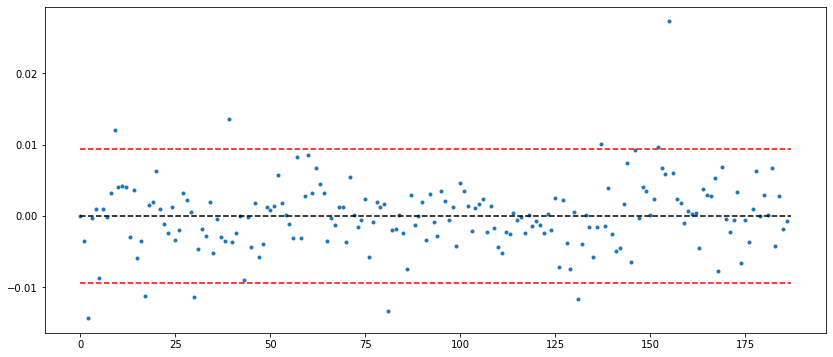

In [13]:
desvio_padrao = analise_df["CARTEIRA"].std()
media = analise_df["CARTEIRA"].mean()

intervalo = norm.interval(alpha=0.95, loc=media, scale=desvio_padrao)
ax = analise_df["CARTEIRA"].plot(style = ".")
ax.figure.set_size_inches(14, 6)
ax.hlines(y=media, xmin = 0, xmax = len(analise_df["CARTEIRA"]), colors="black", linestyles="dashed")
ax.hlines(y=intervalo[0], xmin = 0, xmax = len(analise_df["CARTEIRA"]), colors="red", linestyles="dashed")
ax.hlines(y=intervalo[1], xmin = 0, xmax = len(analise_df["CARTEIRA"]), colors="red", linestyles="dashed")

#### Referente ao IBOV

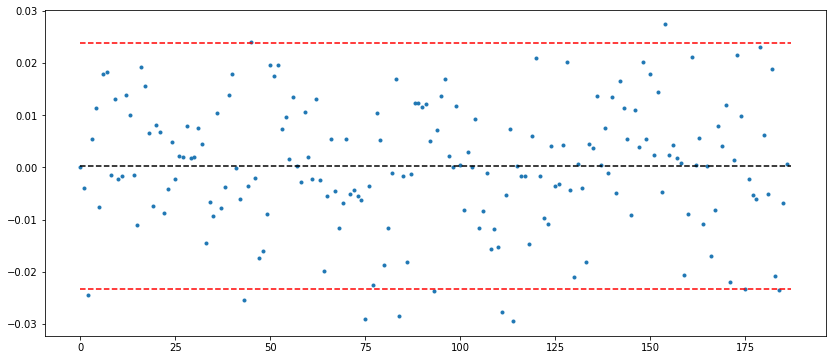

In [14]:
desvio_padrao = analise_df["^BVSP"].std()
media = analise_df["^BVSP"].mean()

intervalo = norm.interval(alpha=0.95, loc=media, scale=desvio_padrao)
ax = analise_df["^BVSP"].plot(style=".")
ax.figure.set_size_inches(14, 6)
ax.hlines(y=media, xmin=0, xmax=len(analise_df["^BVSP"]), colors="black", linestyles="dashed")
ax.hlines(y=intervalo[0], xmin=0, xmax=len(analise_df["^BVSP"]), colors="red", linestyles="dashed")
ax.hlines(y=intervalo[1], xmin=0, xmax=len(analise_df["^BVSP"]), colors="red", linestyles="dashed")

In [15]:
significancia = 0.05
tamanho_amostra = 100

amostra_1_carteira = analise_df["CARTEIRA"].sample(n=tamanho_amostra, random_state=5)
amostra_2_carteira = analise_df["CARTEIRA"].sample(n=tamanho_amostra, random_state=4)
amostra_3_carteira = analise_df["CARTEIRA"].sample(n=tamanho_amostra, random_state=3)

amostra_1_ibovespa = analise_df["^BVSP"].sample(n=tamanho_amostra, random_state=5)
amostra_2_ibovespa = analise_df["^BVSP"].sample(n=tamanho_amostra, random_state=4)
amostra_3_ibovespa = analise_df["^BVSP"].sample(n=tamanho_amostra, random_state=3)

### Teste de Levene  
  
  "Em estatística, o teste de Levene é uma estatística inferencial usada para avaliar a igualdade de variâncias de uma variável calculada para dois ou mais grupos. Alguns procedimentos estatísticos comuns presumem que as variâncias das populações das quais as diferentes amostras são extraídas são iguais." (Wikipedia)

In [16]:
stat_teste, p_valor = levene(amostra_1_carteira, amostra_2_carteira, amostra_3_carteira)
print(f"Estatística-teste: {stat_teste}")
print(f"P-valor: {p_valor}")

if p_valor <= significancia:
    print("Há perturbação aleatória.")
else:
    print("Não há perturbação aleatória.")

Estatística-teste: 0.2636869484912357
P-valor: 0.7683936478866361
Não há perturbação aleatória.


In [17]:
stat_teste, p_valor = levene(amostra_1_ibovespa, amostra_2_ibovespa, amostra_3_ibovespa)
print(f"Estatística-teste: {stat_teste}")
print(f"P-valor: {p_valor}")

if p_valor <= significancia:
    print("Há perturbação aleatória.")
else:
    print("Não há perturbação aleatória.")



Estatística-teste: 0.08876495141515514
P-valor: 0.9150848986203914
Não há perturbação aleatória.


Como resultado, "Não há perturbação aleatória", podemos concluir que o “ruído” ou perturbação aleatória na relação entre as variáveis independentes e a variável dependente é o mesmo em todos os valores das variáveis independentes, para os casos da carteira e para os casos do ibov.

### Teste de Bartlett

In [18]:
stat_teste, p_valor = bartlett(amostra_1_carteira, amostra_2_carteira, amostra_3_carteira)
print(f"Estatística-teste: {stat_teste:0.4f}")
print(f"P-valor: {p_valor:0.4f}")

if p_valor <= significancia:
    print("Há perturbação aleatória.")
else:
    print("Não há perturbação aleatória.")

Estatística-teste: 3.6570
P-valor: 0.1607
Não há perturbação aleatória.


In [19]:
stat_teste, p_valor = bartlett(amostra_1_ibovespa, amostra_2_ibovespa, amostra_3_ibovespa)
print(f"Estatística-teste: {stat_teste:0.4f}")
print(f"P-valor: {p_valor:0.4f}")

if p_valor <= significancia:
    print("Há perturbação aleatória.")
else:
    print("Não há perturbação aleatória.")

Estatística-teste: 0.1221
P-valor: 0.9408
Não há perturbação aleatória.


Como resultado, "Não há perturbação aleatória", de forma semelhante ao Teste de Leneve, podemos concluir que a perturbação aleatória na relação entre as variáveis independentes e a variável dependente é o mesmo em todos os valores das variáveis independentes, para os casos da carteira e para os casos do ibov.

## ANOVA

Como visto em sala, sabemos que os erros possuem variância comum. Para detectar isso, realizaremos os testes de Levene e Bartlett. Considerando os seguintes pressupostos:
- Normalidade;
- Variâncias Iguais;
- Independência.

Onde:
H0: μ1=μ2=μ3=...=μn

H1: nem todas as médias de taxa de retorno são iguais.

In [20]:
analise_df_melted = pd.melt(analise_df, id_vars=["Date"], value_vars=["CARTEIRA", "^BVSP"])
analise_df_melted.columns = ["Date", "Tipo", "Taxa de Retorno"]
analise_df_melted

,Date,Tipo,Taxa de Retorno
0,2022-01-03,CARTEIRA,0.000000
1,2022-01-04,CARTEIRA,-0.003483
2,2022-01-05,CARTEIRA,-0.014345
3,2022-01-06,CARTEIRA,-0.000279
4,2022-01-07,CARTEIRA,0.001011
...,...,...,...
369,2022-09-22,^BVSP,0.018885
370,2022-09-23,^BVSP,-0.020852
371,2022-09-26,^BVSP,-0.023567
372,2022-09-27,^BVSP,-0.006787


In [21]:
# Create ANOVA backbone table
data = [
    ["Entre grupos", "", "", "", "", "", ""], 
    ["Dentro dos grupos", "", "", "", "", "", ""], 
    ["Total", "", "", "", "", "", ""]
]
anova_table = pd.DataFrame(data, columns = ["Fonte da Variação", "SS", "df", "MS", "F", "P-value", "F crit"])
anova_table.set_index("Fonte da Variação", inplace = True)

# calculate SSTR and update anova table
x_bar = analise_df_melted["Taxa de Retorno"].mean()
SSTR = analise_df_melted.groupby("Tipo").count() * (analise_df_melted.groupby("Tipo").mean() - x_bar)**2
anova_table["SS"]["Entre grupos"] = SSTR["Taxa de Retorno"].sum()

# calculate SSE and update anova table
SSE = (analise_df_melted.groupby("Tipo").count() - 1) * analise_df_melted.groupby("Tipo").std()**2
anova_table["SS"]["Dentro dos grupos"] = SSE["Taxa de Retorno"].sum()

# calculate SSTR and update anova table
SSTR = SSTR["Taxa de Retorno"].sum() + SSE["Taxa de Retorno"].sum()
anova_table["SS"]["Total"] = SSTR

# update degree of freedom
anova_table["df"]["Entre grupos"] = analise_df_melted["Tipo"].nunique() - 1
anova_table["df"]["Dentro dos grupos"] = analise_df_melted.shape[0] - analise_df_melted["Tipo"].nunique()
anova_table["df"]["Total"] = analise_df_melted.shape[0] - 1

# calculate MS
anova_table["MS"] = anova_table["SS"] / anova_table["df"]

# calculate F
F = anova_table["MS"]["Entre grupos"] / anova_table["MS"]["Dentro dos grupos"]
anova_table["F"]["Entre grupos"] = F

# p-value
anova_table["P-value"]["Entre grupos"] = 1 - f.cdf(F, anova_table["df"]["Entre grupos"], anova_table["df"]["Dentro dos grupos"])

# F critical
alpha = 0.05
# possible types "right-tailed, left-tailed, two-tailed"
tail_hypothesis_type = "two-tailed"
if tail_hypothesis_type == "two-tailed":
    alpha /= 2
anova_table["F crit"]["Entre grupos"] = f.ppf(1-alpha, anova_table["df"]["Entre grupos"], anova_table["df"]["Dentro dos grupos"])

# Final ANOVA Table
anova_table

,SS,df,MS,F,P-value,F crit
Fonte da Variação,,,,,,
Entre grupos,0.000005,1,0.000005,0.057434,0.810731,5.064805
Dentro dos grupos,0.0313,372,0.000084,,,
Total,0.031305,373,0.000084,,,


In [22]:
stat_teste, p_valor = f_oneway(analise_df["CARTEIRA"], analise_df["^BVSP"])

if p_valor <= significancia:
    print("Há perturbação aleatória.")
else:
    print("Não há perturbação aleatória.")



Não há perturbação aleatória.


# Regressão linear

A análise de regressão linear é usada para prever o valor de uma variável com base no valor de outra. A variável que deseja prever é chamada de variável dependente. A variável que é usada para prever o valor de outra variável é chamada de variável independente. (IBM)

## Visualizar Dados

In [187]:
#BRL=X -> preço do dólar em reais;
#CL=F -> preço barril petróleo em dólar;
dolar_ibov = ['BRL=X', 'PETR4.SA', 'CARE11.SA', 'GOLD11.SA', '^BVSP']

dolar_ibov_df = pd.DataFrame()

for di in dolar_ibov:
    dolar_ibov_df[di] = data.DataReader(di, data_source='yahoo', start='2021-05-01')['Close']

dolar_ibov_df.reset_index(inplace=True)
dolar_ibov_df = dolar_ibov_df.dropna() # Remover os NAN.
dolar_ibov_df

,Date,BRL=X,PETR4.SA,CARE11.SA,GOLD11.SA,^BVSP
1,2021-05-03,5.438100,23.430000,0.72,10.39,119209.000000
2,2021-05-04,5.442600,22.889999,0.74,10.37,117712.000000
3,2021-05-05,5.352700,23.830000,0.73,10.33,119564.000000
4,2021-05-06,5.273431,23.500000,0.73,10.47,119921.000000
6,2021-05-10,5.222200,24.700001,0.74,10.28,121909.000000
...,...,...,...,...,...,...
364,2022-09-22,5.115500,31.940001,3.97,9.08,114070.000000
366,2022-09-26,5.389400,29.290001,3.95,9.29,109114.000000
367,2022-09-27,5.378100,29.670000,4.02,9.30,108376.000000
368,2022-09-28,5.374200,29.270000,4.03,9.45,108451.000000


## Matriz de correlacão  
  O coneficiente de correlação é uma medida de associação linear entre duas variáveis e situa-se entre -1 e +1, dendo que -1 indica associ;áo negativa perfeita e +1 indica associção positiva perfeita.

In [161]:
dolar_ibov_df.corr().round(4)

,BRL=X,PETR4.SA,CARE11.SA,GOLD11.SA,^BVSP
BRL=X,1.0000,-0.4088,-0.4391,0.6814,-0.4485
PETR4.SA,-0.4088,1.0000,0.6565,-0.3217,-0.1519
CARE11.SA,-0.4391,0.6565,1.0000,-0.5239,-0.4571
GOLD11.SA,0.6814,-0.3217,-0.5239,1.0000,-0.2109
^BVSP,-0.4485,-0.1519,-0.4571,-0.2109,1.0000


Algumas considerações:
1. Quando o dólar sobe, o preço do PETR4 e do IBOV caem, sendo este último mais fortemente.
2. PETR4 e IBOV se comportam de forma bem semelhante.
3. GOLD11 sobe junto com o Dólar.
4. CARE11, um fundo de investimento imobiliário de tijolo, tem relação inversa com o valor do dólar. 

## Análises gráficas

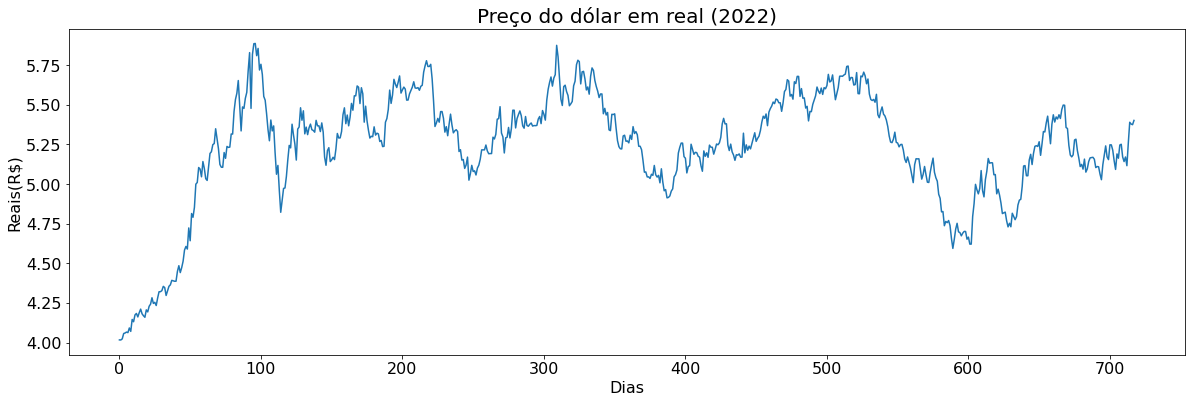

In [100]:
fig, ax = plt.subplots(figsize = (20, 6))

ax.set_title('Preço do dólar em real (2022)', fontsize=20)
ax.set_ylabel('Reais(R$)', fontsize=16)
ax.set_xlabel('Dias', fontsize=16)
ax = dolar_ibov_df['BRL=X'].plot(fontsize=16)

## Box Plot

Trata-se de um gráfico que ajuda a identificar simetria ou assimetria do conjunto de dados e a presença de outliers. Imagem abaixo contem 3 exemplos que evidenciam bem assimetrias e simetria. 
![title](boxplot.png)

### Box Plot da variável dependente (y)

<AxesSubplot:title={'center':'Preço do dólar em real (2020-2022)'}, ylabel='Reais(R$)'>

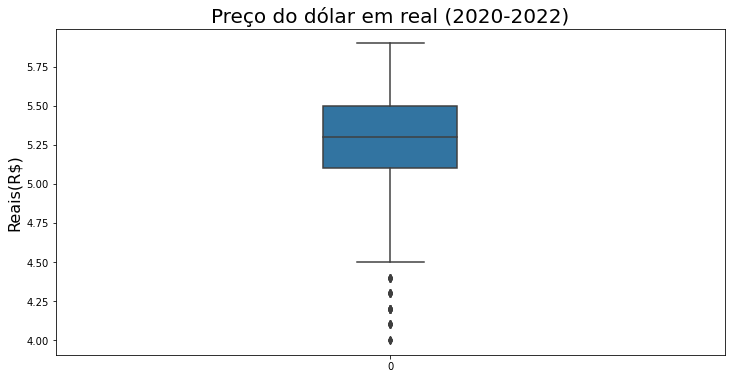

In [102]:
import seaborn as sns
ax = sns.boxplot(data=dolar_ibov_df['BRL=X'].round(1), orient='v', width=0.2)
ax.figure.set_size_inches(12, 6)
ax.set_title('Preço do dólar em real (2020-2022)', fontsize=20)
ax.set_ylabel('Reais(R$)', fontsize=16)
ax

### Box Plot considerando duas variáveis 
Para esse ponto, podemos considerar o preço do ouro e do dólar em reais.

<AxesSubplot:title={'center':'Preço do dólar em real vs preço do ouro (2000-2022)'}, xlabel='Preço do Ouro', ylabel='Reais(R$)'>

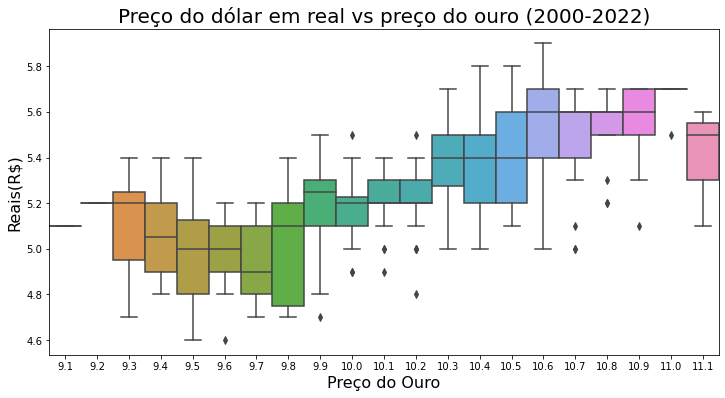

In [103]:
ax = sns.boxplot(
    y=dolar_ibov_df['BRL=X'].round(1), 
    x=dolar_ibov_df['GOLD11.SA'].round(1),
    data=dolar_ibov_df, orient='v', width=1)
ax.figure.set_size_inches(12, 6)
ax.set_title('Preço do dólar em real vs preço do ouro (2000-2022)', fontsize=20)
ax.set_ylabel('Reais(R$)', fontsize=16)
ax.set_xlabel('Preço do Ouro', fontsize=16)
ax

## Distribuição de frequência

<AxesSubplot:title={'center':'Distribuição de Frequência'}, xlabel='BRL=X', ylabel='Reais(R$)'>

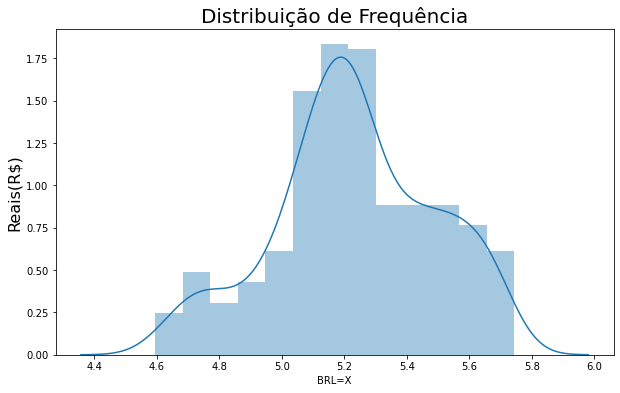

In [163]:
ax = sns.distplot(dolar_ibov_df['BRL=X'], )
ax.figure.set_size_inches(10, 6)
ax.set_title('Distribuição de Frequência', fontsize=20)
ax.set_ylabel('Reais(R$)', fontsize=16)
ax

### seaborn.pairplot
Plota o relacionamento entre pares de variáveis em um dataset.

In [136]:
'''ax = sns.pairplot(dolar_ibov_df)'''

'ax = sns.pairplot(dolar_ibov_df)'

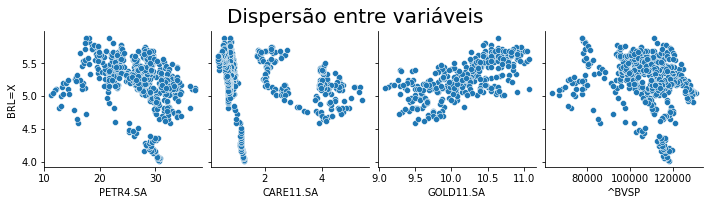

In [115]:
ax = sns.pairplot(dolar_ibov_df, y_vars = 'BRL=X', x_vars=['PETR4.SA', 'CARE11.SA', 'GOLD11.SA', '^BVSP'])
ax.fig.suptitle('Dispersão entre variáveis', fontsize = 20, y = 1.10)
ax

Podemos observar no gráfico 3, GOLD11.SA, que o valor do dólar em real sobe em alinhamento com o valor do ouro subindo também.

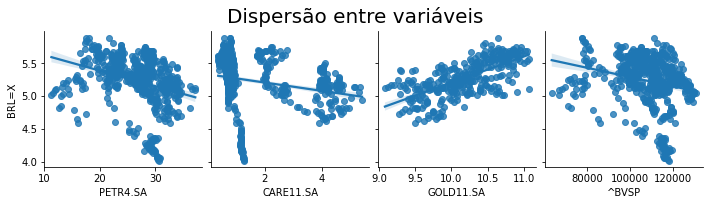

In [139]:
ax = sns.pairplot(
    dolar_ibov_df, 
    y_vars = 'BRL=X', 
    x_vars=['PETR4.SA', 'CARE11.SA', 'GOLD11.SA', '^BVSP'], 
    kind='reg')
ax.fig.suptitle('Dispersão entre variáveis', fontsize = 20, y = 1.10)
ax

## Regressão linear  
Diz respeito ao estudo da dependência de uma variável (dependente) em relação a uma ou mais variáveis exploratórias (explicativas), visando estimar e/ou prever o valor médio da primeira em termos dos valores conhecidos ou fixados das segundas.

In [173]:
from sklearn.model_selection import train_test_split

In [185]:
y = dolar_ibov_df['BRL=X']
X = dolar_ibov_df[['PETR4.SA', 'CARE11.SA', 'GOLD11.SA']]

### Dataframe de treino e teste

In [176]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=2811)

In [177]:
X_train

,PETR4.SA,CARE11.SA,GOLD11.SA
333,37.110001,4.70,9.69
238,32.990002,3.79,9.87
198,32.070000,2.02,10.19
348,33.230000,4.08,9.45
291,29.270000,4.25,9.87
...,...,...,...
73,28.670000,0.76,9.82
68,26.280001,0.77,10.08
215,NaN,NaN,NaN
341,32.410000,4.13,9.53


In [183]:
X_test

,PETR4.SA,CARE11.SA,GOLD11.SA
5,NaN,NaN,NaN
324,32.290001,4.68,9.64
249,31.270000,4.35,9.84
26,28.290001,0.79,10.25
49,27.490000,0.75,10.19
...,...,...,...
256,30.110001,3.93,9.84
143,26.540001,0.38,11.05
46,28.850000,0.78,9.78
232,32.049999,2.89,10.04


In [179]:
y_train

333    5.0937
238    4.7697
198    5.2609
348    5.1817
291    5.1134
        ...  
73     5.2182
68     5.1682
215    5.1594
341    5.1561
84     5.2516
Name: BRL=X, Length: 259, dtype: float64

In [180]:
y_test

5      5.235500
324    5.182700
249    4.701000
26     5.045200
49     5.258000
         ...   
256    4.876200
143    5.528700
46     5.088459
232    4.910000
45     5.059200
Name: BRL=X, Length: 111, dtype: float64

### Função de Regressão com Três Variáveis


In [182]:
from sklearn.linear_model import LinearRegression
from sklearn import metrics
modelo = LinearRegression()
modelo.fit(X_train, y_train)

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [140]:
retornos = dolar_ibov_df.drop(0, axis=0)

#### Estatística descritivas

In [141]:
dolar_ibov_df.describe().round(2)

,BRL=X,PETR4.SA,CARE11.SA,GOLD11.SA,^BVSP
count,718.00,601.00,601.00,339.00,601.00
mean,5.23,26.56,1.58,10.19,108206.30
std,0.36,4.93,1.35,0.47,12475.78
min,4.02,11.29,0.38,9.08,63570.00
25%,5.10,23.08,0.73,9.86,101945.00
50%,5.27,27.67,0.82,10.19,110547.00
75%,5.48,29.72,2.07,10.57,116662.00
max,5.89,37.23,5.40,11.07,130776.00


In [149]:
figura = px.line(title = 'Preço Dólar x Ouro (GOLD11.SA)')
figura.add_scatter(
    x = retornos["Date"],
    y = retornos['BRL=X'],
    name = 'Preco Dolar',  
    line_color = 'green')
figura.add_scatter(
    x = retornos["Date"],
    y = retornos['GOLD11.SA'], 
    name = 'Ouro (GOLD11.SA)', 
    line_color = 'orange')
figura.add_hline(y = retornos['BRL=X'].mean(), line_color="green", line_dash="dot")
figura.show()


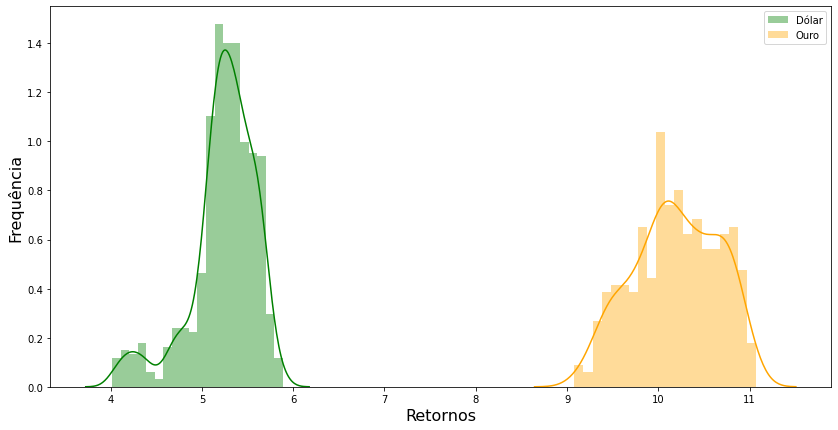

In [164]:


fig, ax = plt.subplots(figsize=(14,7))
ax = sns.distplot(retornos['BRL=X'], bins=20, label='Dólar', color = 'green')
ax = sns.distplot(retornos['GOLD11.SA'], bins=20, label='Ouro', color = 'orange')
ax.set_xlabel("Retornos",fontsize=16)
ax.set_ylabel("Frequência",fontsize=16)
plt.legend();



In [170]:
import statsmodels.api as sm
retornos_lm     = retornos
retornos_lm     = retornos_lm.drop(
    labels=['BRL=X', 'PETR4.SA', 'CARE11.SA', 'GOLD11.SA', '^BVSP'], 
    axis = 1)
retornos_treino = retornos_lm.sample(frac=0.5)
retornos_teste  =   retornos_lm.drop(retornos_treino.index)
retornos_treino

,Date
129,2020-06-29
154,2020-08-03
17,2020-01-24
345,2021-04-27
691,2022-08-24
...,...
639,2022-06-13
354,2021-05-10
687,2022-08-18
618,2022-05-15


In [167]:
x = retornos_treino['^BVSP']
y = retornos_treino['BTCR11.SA']
x = sm.add_constant(x)

model = sm.OLS(y, x).fit()
predictions = model.predict(x) 

print_model = model.summary()
print(print_model)

KeyError: '^BVSP'

eval_env: 1


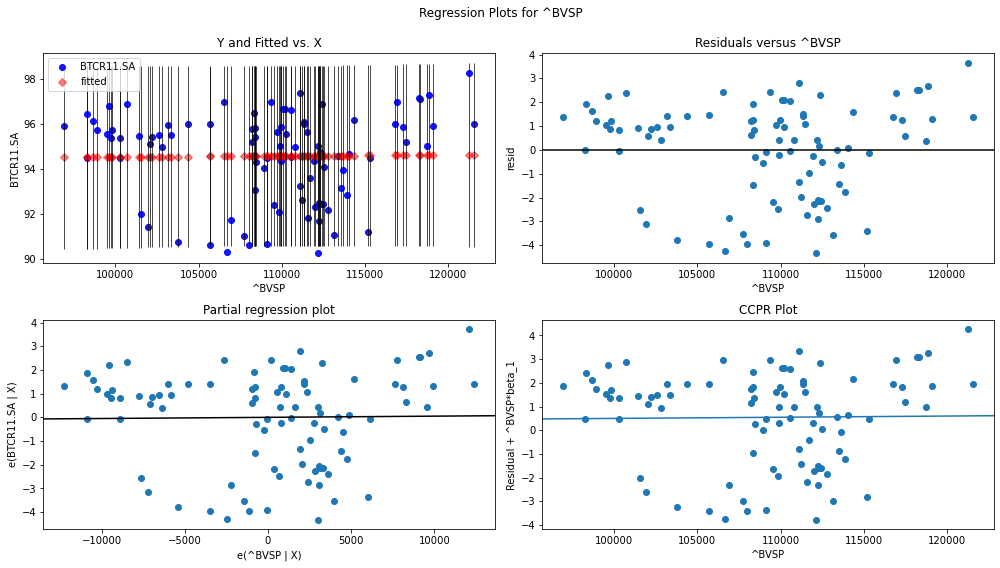

In [63]:


fig = plt.figure(figsize=(14, 8))
fig = sm.graphics.plot_regress_exog(model,
                                    '^BVSP',
                                    fig=fig);

